In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from jmeterConfig import *

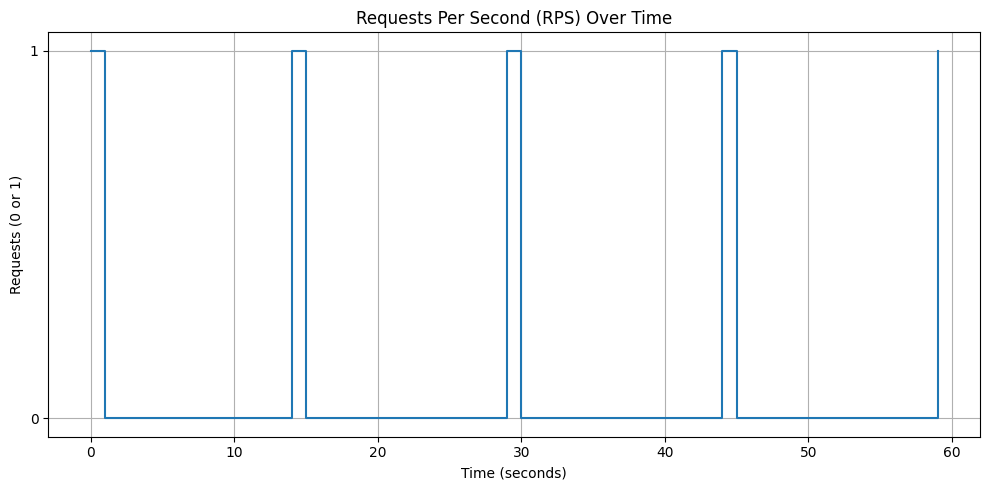

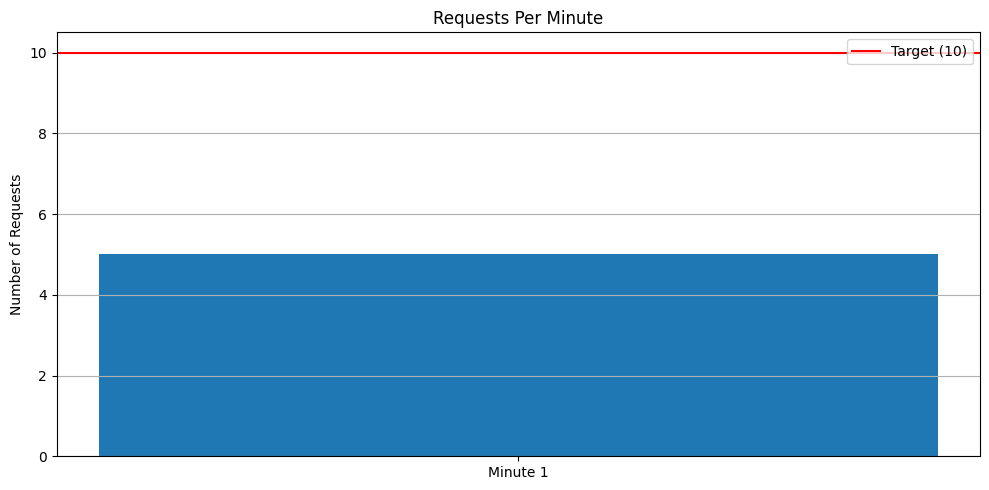

Requests per minute: [5]
Total requests: 5
Average RPS: 0.083


In [2]:
seconds = 60  # Changed from 180 to 300 (5 minutes)
requestsPerMinute = 5

requests_per_second = np.zeros(seconds, dtype=int)

# For each minute, distribute requests evenly
for minute in range(seconds // 60):
    start_idx = minute * 60
    end_idx = start_idx + 60

    # Create evenly spaced requests within this minute
    # We'll place one request every 10 seconds
    request_indices = np.linspace(start_idx, end_idx - 1, requestsPerMinute, dtype=int)
    requests_per_second[request_indices] = 1

# Handle any remaining seconds (if total seconds isn't divisible by 60)
if seconds % 60 > 0:
    start_idx = (seconds // 60) * 60
    end_idx = seconds
    remaining_seconds = end_idx - start_idx
    
    # Calculate how many requests should be in this partial minute (proportional)
    remaining_requests = min(int(requestsPerMinute * remaining_seconds / 60), remaining_seconds)
    
    if remaining_requests > 0:
        # Distribute them evenly in the remaining seconds
        request_indices = np.linspace(start_idx, end_idx - 1, remaining_requests, dtype=int)
        requests_per_second[request_indices] = 1

df = pd.DataFrame({'Time': range(seconds), 'RPS': requests_per_second})
df.to_csv("workloadProfile.csv", index = False, sep = ';')

# Count requests per minute to verify
requests_per_minute = np.array([
    np.sum(requests_per_second[i:i+60]) for i in range(0, seconds, 60)
])

# Just to have a visual understanding, let's plot it
plt.figure(figsize = (10, 5))
plt.step(df['Time'], df['RPS'], where='post')
plt.title('Requests Per Second (RPS) Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Requests (0 or 1)')
plt.yticks([0, 1])
plt.grid(True)
plt.tight_layout()

# Show the request distribution per minute
plt.figure(figsize = (10, 5))
minute_labels = [f"Minute {i+1}" for i in range(len(requests_per_minute))]
plt.bar(minute_labels, requests_per_minute)
plt.title('Requests Per Minute')
plt.ylabel('Number of Requests')
plt.axhline(y=10, color='r', linestyle='-', label='Target (10)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()

print(f"Requests per minute: {requests_per_minute}")
print(f"Total requests: {np.sum(requests_per_second)}")
print(f"Average RPS: {np.mean(requests_per_second):.3f}")

In [4]:
# File where we have defined the specific workload behaviour
workload = 'workloadProfile.csv'

# Data of the Concurrency Thread Group
concurrencyValues = {

    "TargetLevel": "2",    
    "RampUp": "0",                          
    "Steps": "1",
    "Hold": "3"

}

# Data of the HTTP Request
httpValues = {

    "HTTPSampler.domain": "host.docker.internal",
    "HTTPSampler.port": "5000",
    "HTTPSampler.path": "/run-fire-detector",
    "HTTPSampler.method": "POST"
}

jsonBody = '''{}'''

# Let's create the configuration file now!
configFile = 'JM/scripts/jmeterConfigurationFile.jmx'
baseFile = '[Structure] Matrix Multiplication Requests.jmx'

tree = ET.parse(baseFile)
root = tree.getroot()

root = writeConcurrencyThread(root, concurrencyValues)
root = writeHTTPRequest(root, httpValues, jsonBody)
root = writeWorkload(root, workload, configFile)

tree.write(configFile, encoding = 'utf-8', xml_declaration = True)
print('File correctly saved!')

File correctly saved!
